In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
import importlib
import coffea.util as util
import time
import json
import os

sys.path.append("../../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines

sample_cfg_dir = "../../configs/sample_configs/"
histo_cfg_dir = "../../configs/histo_configs/"
cut_cfg_dir = "../../configs/cut_configs/"

In [2]:
# load in a "sample config file" for the 2018 signal samples
with open(sample_cfg_dir+"signal_v2_2018_aEM.json","r") as fin:
    sig_cfg = json.load(fin)

In [3]:
# look at one of the entries
sig_cfg[0]

{'location': '/store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1/',
 'Mchi': 10.5,
 'dMchi': 1.0,
 'ctau': 1,
 'name': 'sig_Mchi-10.5_dMchi-1.0_ct-1',
 'sum_wgt': 9.160776812677796e-07,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 41339.815,
 'nFiles': 6,
 'num_events': 189059,
 'blacklist': []}

Here's what this information means:
- `location` : the directory where all the `.root` files for this signal sample are located 
- `Mchi`, `dMchi`, `ctau` : model parameters for this signal point
- `name` : name for the signal sample
- `sum_wgt` : sum of the Monte Carlo event weights for all events in this sample (relevant for filling histograms)
- `type`,`year` : Information on what kind of sample this is (signal, in this case), and what data-taking year the Monte Carlo generation was configured to reproduce
- `alphaD` : parameter setting for the dark matter U(1) coupling constant. `aEM` means it's set equal to the electromagnetic coupling.
- `xsec` : production cross section for this signal
- `nFiles` : number of `.root` files in the sample
- `num_events` : number of events in the sample
- `blacklist` : list of any corrupted or unusable `.root` files (rare for this to happen)

Now, let's make a list of all the `.root` files for this sample. We will use the `XRootD` package to interact with the `eos` filesystem, where the `.root` files are stored.

In [4]:
from XRootD import client
loc = sig_cfg[0]['location']
blacklist = sig_cfg[0]['blacklist']
xrdClient = client.FileSystem("root://cmseos.fnal.gov")
status, flist = xrdClient.dirlist(loc) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList = ["root://cmseos.fnal.gov/"+loc+"/"+item.name for item in flist if (('.root' in item.name) and (item.name not in blacklist))]


In [5]:
fullList

['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_00.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_01.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_02.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_03.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_04.root',
 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-10p5_dMchi-1p0/ctau-1//ntuples_Mchi-10p5_dMchi-1p0_ctau-1_05.root']

Now we will use the uproot package to load in a ROOT file and look at its contents. All of the event data is stored in a `TTree` object called `outT` inside the `ntuples` directory of the file.

In [6]:
# open the first file in the list
t = uproot.open(fullList[0])['ntuples/outT']

In [7]:
t

<TTree 'outT' (296 branches) at 0x7f649c3fbfd0>

We see that the TTree has 296 "branches". Each branch records the value(s) of some variable for each event (e.g. electron $p_T$ or missing transverse energy)

In [8]:
print("\n".join(t.keys()))

trigFired
trigFired16
trigFired17
trigFired18
eventNum
lumiSec
runNum
METFiltersFailBits
nElectron
Electron_pt
Electron_eta
Electron_etaErr
Electron_phi
Electron_phiErr
Electron_IDcutVeto
Electron_IDcutLoose
Electron_IDcutMed
Electron_IDcutTight
Electron_IDmvaIso90
Electron_IDmvaIso80
Electron_IDmvaIsoLoose
Electron_IDmva90
Electron_IDmva80
Electron_IDmvaLoose
Electron_angRes
Electron_e
Electron_vxy
Electron_vz
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_trkChi2
Electron_trkIso
Electron_trkRelIso
Electron_calIso
Electron_calRelIso
Electron_PFIso4
Electron_PFRelIso4
Electron_PFIso3
Electron_PFRelIso3
Electron_PFIso8
Electron_PFRelIso8
Electron_PFIso
Electron_PFRelIso
Electron_trkProb
Electron_numTrackerHits
Electron_numPixHits
Electron_numStripHits
Electron_charge
nLptElectron
LptElectron_pt
LptElectron_eta
LptElectron_etaErr
LptElectron_phi
LptElectron_phiErr
LptElectron_ID
LptElectron_angRes
LptElectron_e
LptElectron_vxy
LptElectron_vz
LptElectron_dxy
LptElectron_

There are a lot of entries here! But they're mostly grouped by name, so e.g. `Electron_*` are kinematic quantities for the electrons in each event, `LptElectron_*` are for the low-$p_T$ electrons, and so on.

Let's look at the electrons as an example

In [9]:
ele_pt = t['Electron_pt'].array()
print(ele_pt[:5]) # print the electron pT for the first 5 events

[[52.6], [3.91], [], [], []]


The array `Electron_pt` is a *jagged array*, meaning each event has a variable number of entries (i.e. a variable number of electrons). Jagged arrrays are handled by the `awkward` package. 

Since this is a signal sample, we can also look at variables for the *generator-level* electron and positron in the iDM signal. These are accessed via the `GenEle_*` and `GenPos_*` branches

In [10]:
t["GenEle_pt"].array()

<Array [1.03, 0.421, 2.41, ... 0.0764, 4.39] type='29682 * float32'>

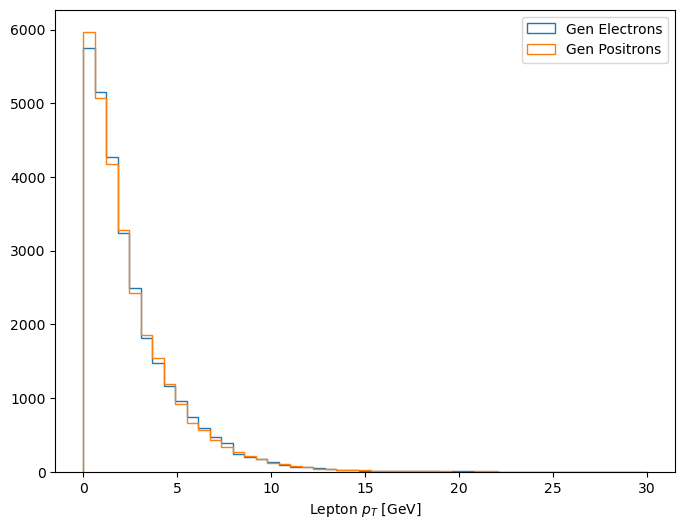

In [11]:
# make a histogram of the gen electron and positron pT
plt.figure(figsize=(8,6))
bins = np.linspace(0,30,50)
h1 = plt.hist(t['GenEle_pt'].array(),bins=bins,histtype='step',label='Gen Electrons')
h1 = plt.hist(t['GenPos_pt'].array(),bins=bins,histtype='step',label='Gen Positrons')
plt.xlabel("Lepton $p_T$ [GeV]")
plt.legend()

Text(0, 0.5, 'Positron $p_T$ [GeV]')

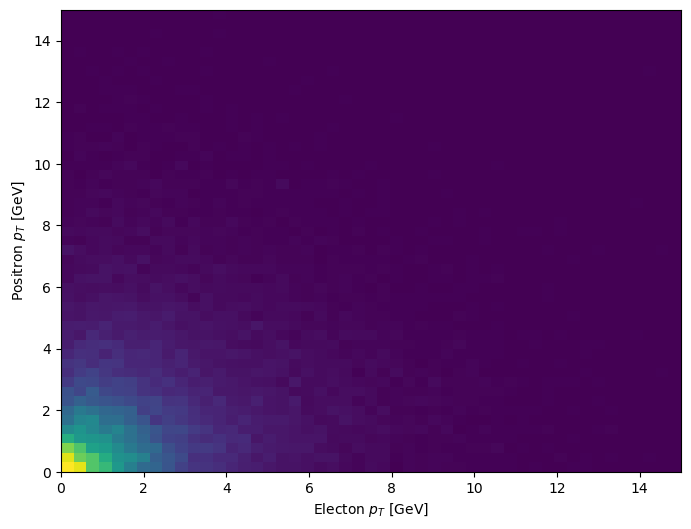

In [12]:
# make a 2D histogram of the gen electron and positron pT
plt.figure(figsize=(8,6))
bins = np.linspace(0,15,50)
h1 = plt.hist2d(t['GenEle_pt'].array(),t['GenPos_pt'].array(),bins=bins)
plt.xlabel("Electon $p_T$ [GeV]")
plt.ylabel("Positron $p_T$ [GeV]")

# An easier way to do file I/O

Uproot is nice for interacting with single files with a few branches, but gets a little cumbersome when there are many branches with long names. Instead, we can use the `coffea` package to interact with the files using the `NanoEvents` format. Here, I use the `loadNano` function from the `analysisTools` python file we imported at the top of tthe notebook. Go check out the source code if you want to know more about how this works!

In [13]:
inFile = fullList[0]
events = tools.loadNano(inFile)

The `events` object now allows us to access event data in a structured way based on the branch names. For instance, all the `Electron` information can be accessed via `events.Electron` etc.

In [14]:
events.fields

['GenEleClosestLpt',
 'GenJet',
 'LptElectron',
 'nPFJetAll',
 'CaloMET',
 'rho',
 'nGenEleTrkMatches',
 'Conversion',
 'runNum',
 'trigFired17',
 'PFJet',
 'trigFired18',
 'nGenPosTrkMatches',
 'GenPos',
 'METFiltersFailBits',
 'GenPosClosest',
 'trigFired16',
 'GenEle',
 'genPosNearTk',
 'genEE',
 'GenPosClosestReg',
 'genWgt',
 'ootPhoton',
 'GenPosClosestLpt',
 'eventNum',
 'GenPart',
 'GenMET',
 'HEM',
 'lumiSec',
 'vtx',
 'GenEleClosest',
 'genEleNearTk',
 'Electron',
 'trigFired',
 'genPU',
 'PFMET',
 'GenEleClosestReg',
 'Photon']

In [15]:
events.Electron.pt

<Array [[52.6], [3.91], ... 6.44], [3.59]] type='29682 * var * float32[parameter...'>

In [16]:
events.LptElectron.pt

<Array [[], [], [], [], ... [], [3.7], [4.12]] type='29682 * var * float32[param...'>

# A basic analysis example
Let's try applying a few basic cuts to the `events` object, which should give you a feel for how columnar analysis works

First, we apply a cut demanding at least 200 GeV of missing energy:

In [17]:
cut1 = events.PFMET.pt > 200
cut1

<Array [False, False, False, ... False, False] type='29682 * bool'>

As you can see, `cut1` is an array of booleans that tell us whether or not each event passes the missing energy cut. Let's apply this cut now

In [19]:
print(f"Before cut : {len(events)} events")
events = events[cut1]
print(f"After cut : {len(events)} events")

Before cut : 29682 events
After cut : 1060 events


In [23]:
events.Electron.fields

['pt',
 'eta',
 'etaErr',
 'phi',
 'phiErr',
 'IDcutVeto',
 'IDcutLoose',
 'IDcutMed',
 'IDcutTight',
 'IDmvaIso90',
 'IDmvaIso80',
 'IDmvaIsoLoose',
 'IDmva90',
 'IDmva80',
 'IDmvaLoose',
 'angRes',
 'e',
 'vxy',
 'vz',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'trkChi2',
 'trkIso',
 'trkRelIso',
 'calIso',
 'calRelIso',
 'PFIso4',
 'PFRelIso4',
 'PFIso3',
 'PFRelIso3',
 'PFIso8',
 'PFRelIso8',
 'PFIso',
 'PFRelIso',
 'trkProb',
 'numTrackerHits',
 'numPixHits',
 'numStripHits',
 'charge']

In [21]:
events.LptElectron.fields

['pt',
 'eta',
 'etaErr',
 'phi',
 'phiErr',
 'ID',
 'angRes',
 'e',
 'vxy',
 'vz',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'trkChi2',
 'trkIso',
 'trkRelIso',
 'calIso',
 'calRelIso',
 'PFIso4',
 'PFRelIso4',
 'PFIso3',
 'PFRelIso3',
 'PFIso8',
 'PFIso',
 'PFRelIso',
 'PFRelIso8',
 'trkProb',
 'numTrackerHits',
 'numPixHits',
 'numStripHits',
 'charge',
 'minDRtoReg']